# Projet Gustave Malachane Kilian Violet

In [ ]:
!py -m pip install requests
!py -m pip install pytest
!py -m pip install exifread

# Premi√®re partie : R√©cup√©ration des donn√©es

Attention ici, si le fichier existe mais qu'il n'y a pas d'image, supprimer le fichier puis relancer le script

In [19]:
import urllib.request
import json
import pandas as pd
import requests
import shutil

# Partie t√©l√©chargement des images
def download_image(url, name):

    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        with open("./images/"+name+".jpg", "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code


# La requ√™te qui r√©cup√®re les donn√©es de wikidata et le traitement
url = "https://query.wikidata.org/sparql?query=Select%20%3Fvolcan%20%3Fimage%20%3Flabel_pays%20%3Fhauteur%20%3Flabel%20%7B%0A%20%20%3Fvolcan%20wdt%3AP31%20wd%3AQ169358%3B%0A%20%20%20%20%20%20%20%20wdt%3AP18%20%3Fimage%3B%0A%20%20%20%20%20%20%20%20wdt%3AP17%20%3Fpays%3B%0A%20%20%20%20%20%20%20%20wdt%3AP2660%20%3Fhauteur%3B%0A%20%20%20%20%20%20%20%20rdfs%3Alabel%20%3Flabel.%0A%20%20%0A%20%20%3Fpays%20rdfs%3Alabel%20%3Flabel_pays.%0A%20%20%0A%20%20FILTER(lang(%3Flabel)%3D%22en%22%20%26%26%20lang(%3Flabel_pays)%3D%22en%22)%0A%7D%0A%0ALIMIT%20150&format=json"
response = urllib.request.urlopen(url)
responsedata = json.loads(response.read().decode("utf-8"))

# Ici on instancie les variables qui serviront pour concevoir le fichier metadata 
array = []
metadata_list = []

# On boucle sur les donn√©es r√©cup√©r√©es pour les inscrire dans le fichier (si le fichier existe pas)
try: 
    with open("metadata.json", "r", encoding="utf-8") as json_file:
        print("Le fichier existe d√©j√†")
except FileNotFoundError:

    for data in responsedata["results"]["bindings"]:

            metadata = {
                "nom": data["label"]["value"],
                "hauteur": data["hauteur"]["value"],
                "pays": data["label_pays"]["value"]            
            }
        
    metadata_list.append(metadata)
    response = download_image(str(data["image"]["value"]).replace("%20", "_").replace("%C3%A1", "a"), metadata["nom"])

    dataframe = pd.DataFrame(array, columns=["label", "image"])
    print(dataframe)

    # Ecriture dans le fichier de metadata
    with open("metadata.json", "w", encoding="utf-8") as json_file:
        json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)
    


Le fichier existe d√©j√†


## R√©cup√©ration des donn√©es exifs des images

Ici gr√¢ce √† la librairie PIL & exifread, nous pouvons acc√©der aux donn√©es exifs de l'image. elles sont ensuite stock√©es dans le fichier JSON metadata.json
On va aussi en profiter pour stocker des "tags" qu'on va d√©finir gr√¢ce aux noms des volcans. On s'en servira plus tard pour analyser nos donn√©es 

In [ ]:
import os
import json
from PIL import Image
import exifread
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image


def get_dominant_colors(image_path, k=5):
    """ Extrait les k couleurs dominantes d'une image avec K-Means """
    with Image.open(image_path) as img:
        img = img.resize((100, 100))  # R√©duire la taille pour acc√©l√©rer le clustering
        img_array = np.array(img).reshape(-1, 3)  # Convertir en tableau de pixels

    # Clustering des couleurs
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(img_array)

    # Convertir les couleurs en hexad√©cimal
    colors = ['#%02x%02x%02x' % tuple(map(int, color)) for color in kmeans.cluster_centers_]
    return colors

# Dossier contenant les images
image_folder = "images"

# Parcourir chaque image
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    try:
        # Ouvrir l'image avec PIL
        with Image.open(image_path) as img:
            width, height = img.size
            format_img = img.format

            colors = get_dominant_colors(image_path)

            # D√©terminer l'orientation
            if width > height:
                orientation = "Paysage"
            elif height > width:
                orientation = "Portrait"
            else:
                orientation = "Carr√©"

        # Lire les m√©tadonn√©es EXIF
        with open(image_path, "rb") as img_file:
            tags = exifread.process_file(img_file, details=False)
            date_creation = tags.get("EXIF DateTimeOriginal", 0000)
            camera_model = tags.get("Image Model", "Inconnu")

        # Stocker les m√©tadonn√©es dans un dictionnaire (metadata_list n'a pas forc√©ment r√©cup√©r√© de donn√©es √† l'√©tape pr√©c√©dente)
        if len(metadata_list) <= 0:
            with open("metadata.json", 'r', encoding="utf-8") as f:
                metadata_list = json.load(f)

        metadataIndex = next((i for i, md in enumerate(metadata_list) if md["nom"]+".jpg" == image_name), -1)

        
        exif = {
            "nom": image_name,
            "chemin": image_path,
            "taille": f"{width}x{height}",
            "format": format_img,
            "orientation": orientation,
            "annee_capture": str(date_creation)[:4], # On a besoin que √ßa soit un entier pour la visualisation plus tard
            "date_creation": str(date_creation),
            "modele_camera": str(camera_model),
            "colors": colors,
        }

        tags = metadata_list[metadataIndex]["nom"].replace("-", " ").replace("_", " ").split()
        
        metadata_list[metadataIndex]["image"] = exif

        # On ne veut pas √©craser les balises qui ont √©t√© ajout√©es √† la main
        if len(metadata_list[metadataIndex]["tags"]) <= 0:
            metadata_list[metadataIndex]["tags"] = tags

    except Exception as e:
        print(f"Erreur avec {image_name} : {e}")

# Sauvegarder les m√©tadonn√©es en JSON
with open("metadata.json", "w", encoding="utf-8") as json_file:
    json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)

print("\n M√©tadonn√©es enregistr√©es dans metadata.json")


Erreur avec Mount Ragang.jpg : Image size (768777555 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Erreur avec Pico do Fogo.jpg : invalid literal for int() with base 10: ''

 M√©tadonn√©es enregistr√©es dans metadata.json


## G√©n√©ration des utilisateurs

### QUESTION : Comment pr√©voyez-vous de traiter ces tags ? Est-il possible d'automatiser ce processus ?

On peut utiliser K-means pour analyser et regrouper les couleurs dominantes.
Ici les donn√©es pr√©sentes dans le fichier metadata.json proviennent essentiellement des exifs r√©cup√©r√©e gr√¢ce √† la librairie exifread.
Il y aussi une partie des donn√©es comme la hauteur, le pays, le nom de l'image et l'image en elle-m√™me qui proviennent de Wikidata. 
Pour les autres tags, on peut demander aux utilisateurs de remplir les tags par images.

In [12]:
import json
import random

# Charger les √©l√©ments du json
with open("metadata.json", "r", encoding="utf-8") as f:
    volcans = json.load(f)

# Nombre de volcans
nombre_total_volcans = len(volcans)
print(f"Nombre total de volcans charg√©s : {nombre_total_volcans}")

pays_connus = ["√âtats-Unis","France","Chine","Royaume-Uni","Allemagne","Inde","Japon","Br√©sil","Russie","Italie"]


# On g√©n√®re des utilisateurs pour une simulation de consultation
utilisateurs = [
    {"id": i, "nom": f"Utilisateur_{i}", "volcans_consult√©s": []}
    for i in range(1, 51)
]

for utilisateur in utilisateurs:
    nb_volcans = random.randint(5, 20)
    age_utilisateur = random.randint(18, 70) 
    origine_utilisateur = random.randint(0, len(pays_connus)-1)
    volcans_choisis = random.sample(volcans, min(nb_volcans, nombre_total_volcans)) # Chaque utilisateur consulte entre 5 et 20 volcans choisi al√©atoirement
    
    # Stocker uniquement le nom des volcans
    utilisateur["volcans_consult√©s"] = [volcan["nom"] for volcan in volcans_choisis]

    # Reste des infos utilisateur qui permettra de faire de meilleures analyses plus tard
    utilisateur["age"] = age_utilisateur
    utilisateur["origine"] = pays_connus[origine_utilisateur]

# Sauvegarde
with open("utilisateurs_volcans.json", "w", encoding="utf-8") as f:
    json.dump(utilisateurs, f, indent=4, ensure_ascii=False)

# Affichage d'un aper√ßu des 5 premiers utilisateurs
print(json.dumps(utilisateurs[:5], indent=4, ensure_ascii=False))  # Afficher les 5 premiers utilisateurs


Nombre total de volcans charg√©s : 128
[
    {
        "id": 1,
        "nom": "Utilisateur_1",
        "volcans_consult√©s": [
            "Cayambe",
            "Soufri√®re",
            "Mount Ragang",
            "Ampato",
            "Mount Douglas",
            "Imbabura Volcano",
            "Camiguin de Babuyanes",
            "Rinjani",
            "Calbuco",
            "Vulcano",
            "Semeru",
            "Kronotsky",
            "Mount Churchill",
            "Mount Balbi",
            "Mount Baker",
            "Mount Iliamna",
            "The Quill",
            "Volc√°n Tajumulco",
            "Licancabur"
        ],
        "age": 26,
        "origine": "France"
    },
    {
        "id": 2,
        "nom": "Utilisateur_2",
        "volcans_consult√©s": [
            "Daisen",
            "Volc√°n de la Deseada",
            "Kao",
            "Iztaccihuatl",
            "Mount Adams",
            "Mount Baker",
            "Ollag√ºe",
            "Tungurahua vo

## Partie analyse des donn√©es

In [ ]:
import json
import pytest
import collections
import matplotlib.pyplot as plt

def charger_donnees(fichier_volcans, fichier_utilisateurs):
    """Charge les donn√©es des volcans et des utilisateurs depuis les fichiers JSON."""
    with open(fichier_volcans, "r", encoding="utf-8") as f:
        volcans = json.load(f)

    with open(fichier_utilisateurs, "r", encoding="utf-8") as f:
        utilisateurs = json.load(f)

    return volcans, utilisateurs

def analyser_preferences(listes_volcans, utilisateurs):
    """Ici on va analyser les volcans d√©j√† consult√©s par l'utilisateur pour ensuite d√©finir leurs pr√©f√©rences"""

    # Analyse des volcans consult√©s
    for utilisateur in utilisateurs:

        # Initialisation des compteurs globaux
        global_colors = collections.Counter()
        global_orientations = collections.Counter()
        global_sizes = collections.Counter()
        global_countries = collections.Counter()
        global_tags = collections.Counter()

        volcans = utilisateur["volcans_consult√©s"]

        for nom_volcan in volcans:
            volcan_data = next((v for v in listes_volcans if v["nom"] == nom_volcan), None)
            if volcan_data:
                if "image" in volcan_data:
                    global_colors.update(volcan_data["image"]["colors"])
                    global_orientations[volcan_data["image"]["orientation"]] += 1

                    if "taille" in volcan_data["image"]:
                        largeur, _ = map(int, volcan_data["image"]["taille"].split("x"))
                        if largeur < 1000:
                            global_sizes["Petite"] += 1
                        elif largeur < 3000:
                            global_sizes["Moyenne"] += 1
                        else:
                            global_sizes["Grande"] += 1
                    
                    global_countries[volcan_data["pays"]] += 1
                
                if "tags" in volcan_data:
                    global_tags.update(volcan_data["tags"])


        """ On modifie l'utilisateur pour avoir ses pr√©f√©rences """
        utilisateur["preference"] = {
            "couleurs": global_colors.most_common(3),
            "orientation": global_orientations.most_common(1),
            "taille": global_sizes.most_common(1),
            "pays": global_countries.most_common(3),
            "tags": global_tags.most_common(3)
        }


    """ On note toutes les pr√©f√©rences dans le fichier """
    with open("utilisateurs_volcans.json", "w", encoding="utf-8") as f:
        json.dump(utilisateurs, f, indent=4, ensure_ascii=False)


    """ On retourne tous les utilisateurs mis √† jour pour s'en servir pour la visualisation """
    return utilisateurs
    

volcans, utilisateurs = charger_donnees("metadata.json", "utilisateurs_volcans.json")    
utilisateurs = analyser_preferences(volcans, utilisateurs)


# Visualisation des donn√©es

Dans cette partie nous allons √©tudier toutes les donn√©es que nous avons r√©cup√©r√©es gr√¢ce √† des graphiques trac√©es avec la librairie matplotlib.
Ici il doit √™tre possible d'avoir une visualisation globale mais aussi par utilisateur

In [ ]:
import matplotlib.pyplot as plot
import pandas as pd
from pandas import json_normalize
import json
import numpy
import math
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import scale, minmax_scale


# On charge le contenu du fichier
data = json.load(open("metadata.json", encoding="utf8"))

### Graphe proportion des volcans par pays

<Axes: title={'center': 'proportion de volcans par pays'}, xlabel='pays'>

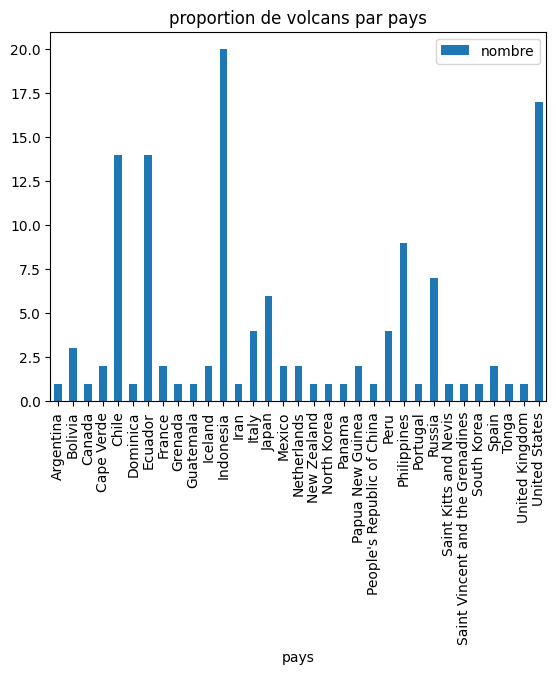

In [6]:
data_normalized = pd.DataFrame(json_normalize(data), columns=["pays", "nom"]).astype(
    dtype={"pays": "<U200", "nom": "<U200"}
)

grouped = data_normalized.groupby("pays").count()
grouped = grouped.rename(columns={"nom": "nombre"}).reset_index()
grouped.plot(x=0, kind="bar", title="proportion de volcans par pays")


# """
#     Le nombre d'images disponibles pour les diff√©rents types : taille de l'image, l'orientation des images, les mod√®les d'appareils photo, etc. 
# """

# array = []
# color_array = []
# for element in data:
#     if "image" in element:
#         if 'nom' in element["image"] and 'orientation' in element["image"] and 'taille' in element["image"] and 'modele_camera' in element["image"]: 
#             imageInfo = element["image"]
#             array.append({imageInfo["nom"], imageInfo["orientation"], imageInfo["taille"], imageInfo["modele_camera"]})
#             color_array.append(imageInfo["colors"])

# df = pd.DataFrame(array, columns=["nom", "orientation", "taille", "modele_camera"])
# df = df.astype(
#     dtype={"nom": "<U200", "orientation": "<U200", "taille": "<U200", "modele_camera": "U200"}
# )

# # TODO: Regrouper par tranche de valeur
# grouped_taille = df.groupby('taille').size()
# grouped_orientation = df.groupby('orientation').size()
# grouped_modele = df.groupby('modele_camera').size()

# (figure, axis) = plot.subplots(3,1, figsize=(30, 25))
# axis[0].bar(grouped_taille.index, grouped_taille.values)
# axis[1].bar(grouped_orientation.index, grouped_orientation.values)
# axis[2].bar(grouped_taille.index, grouped_taille.values)



# """ 
#     Caract√©ristique des couleurs

#     Chaque image a pour donn√©es ces 5 couleurs principales
#     On peut visualiser vers quelles teintes tendent les images que l'on poss√®de

#     On peut visualiser de la mani√®re suivante : 
#     Une courbe de valeur entre #000 et #FFF

# """

# image_RGB = []

# def hex_to_rgb(hex):
#     return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

# for image_colors in color_array:
#     for i,color in image_colors:
#         rgb_color = hex_to_rgb(color)
        


# cluster_count = 1

# count = df.groupby(["orientation", "modele_camera"]).count()

# clusters = KMeans()
# clusters.fit(count)

# unique, frequency = numpy.unique(clusters.labels_, return_counts=True)
# scaled_frequency = minmax_scale(frequency, feature_range=(50, 2000))

# # Diagramme de dispersion 3D
# plot.figure(figsize=(8, 8))
# axes = plot.axes(projection="3d")
# axes.scatter3D(
#     clusters.cluster_centers_[:, 0],
#     clusters.cluster_centers_[:, 1],
# )

# axes.set_xlabel("orientation")
# axes.set_xlabel("modele")
# axes.set_ylabel("count")


### Nombre d'image disponible pour chaque ann√©e 

<Axes: title={'center': "Nombre d'images par an"}, xlabel='image.annee_capture'>

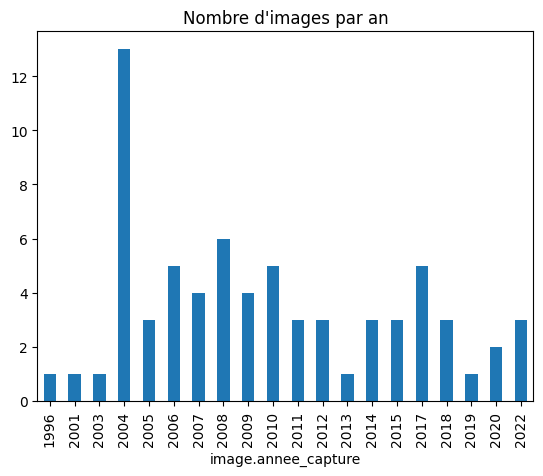

In [3]:
data2_normalized = pd.DataFrame(json_normalize(data, max_level=1), columns=["image.annee_capture", "nom"])
data2_normalized = data2_normalized.drop_duplicates(subset=["nom"], keep="first")

data2_normalized["image.annee_capture"] = pd.to_numeric(data2_normalized["image.annee_capture"], errors="coerce")
data2_normalized["image.annee_capture"] = data2_normalized["image.annee_capture"].fillna(data2_normalized["image.annee_capture"].median())

data2_normalized = data2_normalized.astype(
    dtype={"image.annee_capture": "<i4", "nom": "<U200"}
)

group_by_year = data2_normalized.groupby("image.annee_capture").size()

# Loc permet d'√©liminer l'ann√©e 0 (le premier index)
filtered_year = group_by_year.loc[group_by_year.index > 0]
filtered_year.plot(x=0, kind="bar", title="Nombre d'images par an")

### Nombre d'image par propri√©t√©s

In [ ]:
def plot_data(title, data, color="skyblue"):
    """Affiche un graphique en barres des images par cat√©gorie."""
    if not data:
        print(f"Aucune donn√©e pour {title}")
        return
    
    labels, values = zip(*data)
    plt.bar(labels, values, color=color)
    plt.title(title)
    plt.xlabel("Cat√©gories")
    plt.ylabel("Fr√©quence")
    plt.show()

def generer_rapport(fichier_volcans, fichier_utilisateurs):

    # data contient les mds sur les volcans (d√©but de la partie visualisation)
    
    md_images = []
    for volcan in data:
        if volcan["image"]:
            md_images.append(volcan["image"])
    
    if len(md_images) > 0:
        orientation = pd.DataFrame(json_normalize(data, max_level=1), columns=["orientation", "nom"])

        taille = []
        for image in md_images:
            if "taille" in image:
                largeur, _ = map(int, image["taille"].split("x"))
                if largeur < 1000:
                    taille["Petite"] += 1
                elif largeur < 3000:
                    taille["Moyenne"] += 1
                else:
                    taille["Grande"] += 1
    
    

    """G√©n√®re un rapport d'analyse des pr√©f√©rences des utilisateurs avec affichage de graphiques."""
    volcans, utilisateurs = charger_donnees(fichier_volcans, fichier_utilisateurs)
    
    utilisateurs = analyser_preferences(volcans, utilisateurs)
    
    top_3 = analyser_preferences(volcans, utilisateurs)

    print("üîπ Top 3 Couleurs:", top_3["couleurs"])
    print("üîπ Top 3 Orientations:", top_3["orientations"])
    print("üîπ Top 3 Tailles d'image:", top_3["tailles"])
    print("üîπ Top 3 Pays:", top_3["pays"])
    print("üîπ Top 3 Balises:", top_3["balises"])

    # Affichage des graphiques
    plot_data("Top 3 Couleurs Pr√©f√©r√©es", top_3["couleurs"], color="lightcoral")
    plot_data("Top 3 Orientations Pr√©f√©r√©es", top_3["orientations"], color="gold")
    plot_data("Top 3 Tailles d'Images Pr√©f√©r√©es", top_3["tailles"], color="lightgreen")
    plot_data("Top 3 Pays Pr√©f√©r√©s", top_3["pays"], color="dodgerblue")
    plot_data("Top 3 Balises Pr√©f√©r√©es", top_3["balises"], color="purple")



In [ ]:


# Donn√©es fictives pour les tests
volcans_test = [
    {"nom": "Etna", "pays": "Italie", "image": {"colors": ["#FF0000", "#000000"], "orientation": "Paysage", "taille": "1200x800"}},
    {"nom": "Vesuvius", "pays": "Italie", "image": {"colors": ["#AC0000", "#FF0000"], "orientation": "Portrait", "taille": "900x1600"}},
    {"nom": "Mayon", "pays": "Philippines", "image": {"colors": ["#AA0000", "#550000"], "orientation": "Paysage", "taille": "3000x2000"}},
]

utilisateurs_test = [
    {"id": 1, "volcans_consult√©s": ["Etna", "Vesuvius", "Mayon"]},
    {"id": 2, "volcans_consult√©s": ["Etna", "Mayon"]},
]

def test_analyse_preferences():
    """V√©rifie que la fonction retourne bien un dictionnaire avec des listes de 3 √©l√©ments max."""
    result = analyser_preferences(volcans_test, utilisateurs_test)
    
    assert isinstance(result, dict), "Le r√©sultat doit √™tre un dictionnaire"
    assert all(isinstance(result[key], list) for key in result), "Chaque valeur du dictionnaire doit √™tre une liste"
    
    for key in result:
        assert len(result[key]) <= 3, f"Le top 3 {key} ne doit pas contenir plus de 3 √©l√©ments"

def test_couleurs_dominantes():
    """V√©rifie que les couleurs les plus fr√©quentes apparaissent en premier."""
    result = analyser_preferences(volcans_test, utilisateurs_test)
    top_colors = result["couleurs"]
    print(result["couleurs"])
    assert top_colors[0][0] == "#FF0000", "La couleur dominante devrait √™tre #FF0000"
    assert top_colors[1][0] == "#AA0000", "La deuxi√®me couleur devrait √™tre #AA0000"

def test_pays_populaires():
    """V√©rifie que l'Italie est bien le pays le plus populaire."""
    result = analyser_preferences(volcans_test, utilisateurs_test)
    top_pays = result["pays"]
    print(result["pays"])
    assert top_pays[0][0] == "Italie", "L'Italie devrait √™tre le pays le plus populaire"

def test_tailles_dimages():
    """V√©rifie que les tailles d'images sont bien cat√©goris√©es."""
    result = analyser_preferences(volcans_test, utilisateurs_test)
    top_tailles = dict(result["tailles"])
    print(result["tailles"])

    assert top_tailles["Moyenne"] > 0, "Il devrait y avoir au moins une image de taille moyenne"
    assert top_tailles["Petite"] > 0, "Il devrait y avoir au moins une image de petite taille"
    assert top_tailles["Grande"] > 0, "Il devrait y avoir au moins une image de grande taille"

test_analyse_preferences()
test_couleurs_dominantes()
test_pays_populaires()
test_tailles_dimages()


[('#AA0000', 3), ('#FF0000', 3), ('#550000', 2)]


AssertionError: La couleur dominante devrait √™tre #FF0000

In [26]:
import json
import pytest
import collections
import pandas as pd

# Charger les donn√©es des volcans et des utilisateurs
with open("metadata.json", "r", encoding="utf-8") as f:
    volcans = json.load(f)

with open("utilisateurs_volcans.json", "r", encoding="utf-8") as f:
    utilisateurs = json.load(f)

# Fonction pour recommander des volcans √† un utilisateur
def recommander_volcans(utilisateur, volcans):
    # Comptage des pr√©f√©rences de l'utilisateur
    user_countries = collections.Counter()
    user_tags = collections.Counter()
    user_colors = collections.Counter()

    # R√©cup√©ration des volcans consult√©s par l'utilisateur
    unique_volcans = set(utilisateur["volcans_consult√©s"])

    for nom_volcan in unique_volcans:
        volcan_data = next((v for v in volcans if v["nom"] == nom_volcan), None)
        if volcan_data:
            # Ajout du pays
            user_countries[volcan_data["pays"]] += 1
            # Ajout des balises
            mots_cles = volcan_data["nom"].replace("-", " ").replace("_", " ").split()
            
            user_tags.update(mots_cles)
            # Ajout des couleurs
            if "image" in volcan_data:
                user_colors.update(volcan_data["image"].get("colors", []))

    # D√©terminer les pr√©f√©rences principales
    top_countries = [c[0] for c in user_countries.most_common(3)]
    top_tags = [t[0] for t in user_tags.most_common(3)]
    top_colors = [col[0] for col in user_colors.most_common(3)]

    # Cr√©ation d'une liste de volcans avec un score
    recommandations = []

    for volcan in volcans:
        score = 0

        # V√©rification du pays
        if volcan["pays"] in top_countries:
            score += 3
        
        # V√©rification des balises
        volcans_tags = volcan["nom"].replace("-", " ").replace("_", " ").split()
        for tag in top_tags:
            if tag in volcans_tags:
                score += 2

        # V√©rification des couleurs
        if "image" in volcan:
            for color in top_colors:
                if color in volcan["image"].get("colors", []):
                    score += 1

        # Ajouter √† la liste des recommandations si le score est > 0
        if score > 0:
            recommandations.append({
                "volcan": volcan["nom"],
                "pays": volcan["pays"],
                "score": score
            })

    # Trier les volcans par score d√©croissant et prendre les 5 meilleurs
    recommandations = sorted(recommandations, key=lambda x: x["score"], reverse=True)[:5]

    return recommandations

# G√©n√©rer les recommandations pour chaque utilisateur
recommandations_utilisateurs = {}

for utilisateur in utilisateurs:
    recommandations_utilisateurs[utilisateur["id"]] = recommander_volcans(utilisateur, volcans)

# Sauvegarder les recommandations dans un fichier JSON
with open("recommandations_utilisateurs.json", "w", encoding="utf-8") as f:
    json.dump(recommandations_utilisateurs, f, ensure_ascii=False, indent=4)

print("Les recommandations ont √©t√© sauvegard√©es dans 'recommandations_utilisateurs.json'.")


Les recommandations ont √©t√© sauvegard√©es dans 'recommandations_utilisateurs.json'.


In [40]:


# Donn√©es de test (volcans)
volcans_test = [
    {"nom": "Etna", "pays": "Italy", "image": {"colors": ["#ff0000", "#00ff00"]}},
    {"nom": "Vesuvius", "pays": "Italy", "image": {"colors": ["#ff0000", "#0000ff"]}},
    {"nom": "Mount Fuji", "pays": "Japan", "image": {"colors": ["#ff0000", "#ffff00"]}},
    {"nom": "Mayon", "pays": "Philippines", "image": {"colors": ["#00ff00", "#0000ff"]}},
    {"nom": "Krakatoa", "pays": "Indonesia", "image": {"colors": ["#ff0000", "#00ff00"]}}
]

# Donn√©es de test (utilisateurs)
utilisateur_test = {
    "id": 1,
    "volcans_consult√©s": ["Etna", "Vesuvius", "Mayon"]
}

def test_recommander_volcans():
    """Test que la fonction recommande bien des volcans en fonction des pr√©f√©rences."""
    
    recommandations = recommander_volcans(utilisateur_test, volcans_test)

    # V√©rifier que la recommandation n'est pas vide
    assert len(recommandations) > 0, "‚ùå Aucune recommandation trouv√©e"

    # V√©rifier qu'il n'y a pas de doublons dans les r√©sultats
    noms_volcans = [rec["volcan"] for rec in recommandations]
    assert len(noms_volcans) == len(set(noms_volcans)), "‚ùå Des volcans sont recommand√©s plusieurs fois"

    # V√©rifier que les scores sont tri√©s par ordre d√©croissant
    scores = [rec["score"] for rec in recommandations]
    assert scores == sorted(scores, reverse=True), "‚ùå Les scores ne sont pas tri√©s correctement"

    # V√©rifier que les recommandations sont pertinentes (pays, balises, couleurs)
    volcans_recommand√©s = {rec["volcan"] for rec in recommandations}
    assert "Mount Fuji" in volcans_recommand√©s or "Krakatoa" in volcans_recommand√©s, "‚ùå Les recommandations ne sont pas pertinentes"

    print("‚úÖ Test `recommander_volcans` pass√© avec succ√®s !")

test_recommander_volcans()


‚úÖ Test `recommander_volcans` pass√© avec succ√®s !
